In [154]:
!pip install tf2onnx
!pip install tensorrt
!pip install django
!django-admin startproject myproject


In [153]:
#!rm -rf myproject



In [136]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
import pandas as pd
import os, os.path
import glob
from tensorflow.python.saved_model import tag_constants
import re
from gensim.models import Word2Vec
import random
import math
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import onnx
import tensorflow as tf
import tf2onnx
import tensorrt as trt
from tf2onnx import convert
import tensorrt as trt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

## Data Collection:

In [ ]:
drive.mount('/content/drive')
# access to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [ ]:


file_id = '12UXxo5aazNsrx15JlRhD71WGzFH8QtFU' #<-- You add in here the id from you google drive file, you can find it

download = drive.CreateFile({'id': file_id})

# Download the file to a local disc
download.GetContentFile('data.zip')

In [ ]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: OCR_Text/9872.txt       
  inflating: OCR_Text/12356.jpg      
  inflating: OCR_Text/13114.jpg      
  inflating: OCR_Text/13270.txt      
  inflating: OCR_Text/14586.jpg      
  inflating: OCR_Text/14613.jpg      
  inflating: OCR_Text/14781.jpg      
  inflating: OCR_Text/16862.jpg      
  inflating: OCR_Text/18422.txt      
  inflating: OCR_Text/18457.txt      
  inflating: OCR_Text/18754.jpg      
  inflating: OCR_Text/18936.jpg      
  inflating: OCR_Text/363.txt        
  inflating: OCR_Text/1921.jpg       
  inflating: OCR_Text/2180.jpg       
  inflating: OCR_Text/2211.jpg       
  inflating: OCR_Text/2244.jpg       
  inflating: OCR_Text/2482.txt       
  inflating: OCR_Text/3215.txt       
  inflating: OCR_Text/4332.txt       
  inflating: OCR_Text/6359.txt       
  inflating: OCR_Text/8536.jpg       
  inflating: OCR_Text/9319.txt       
  inflating: OCR_Text/9887.txt       
  inflating: OCR_Text/10811.txt      

In [ ]:
!ls

data.zip  drive  OCR_Text  sample_data


## Data Exploration

In [ ]:
# path joining version for other paths
DIR = 'OCR_Text'
print (len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

39967


In [ ]:
#images path
directory = 'OCR_Text'


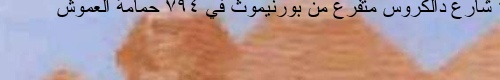

In [106]:
image = cv2.imread(directory+'/0.jpg')
cv2_imshow(image)

In [ ]:
image.shape

(80, 500, 3)

In [ ]:
print(len(image))

80


In [ ]:
image.dtype

dtype('uint8')

## Images Preprocessing:

Convert to grayscale

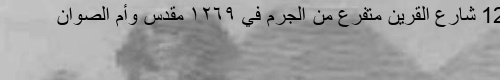

In [ ]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

In [ ]:
gray_image.shape

(80, 500)

In [ ]:
gray_image.dtype

dtype('uint8')

Contrast Adjustment

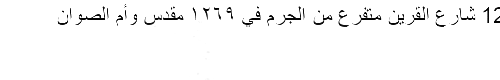

In [ ]:

alpha = 2.2  # Contrast control (1.0 for original image)
beta = 1  # Brightness control (0 for no brightness change)
adjusted_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)
cv2_imshow(adjusted_image)

In [ ]:
adjusted_image.shape

(80, 500)

Gaussian blur

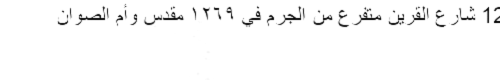

In [ ]:
ksize = (3, 3)  # Kernel size
sigmaX = 0.5   # Standard deviation in the X direction (0 for auto-calculate)
G_blurred_image = cv2.GaussianBlur(adjusted_image, ksize, sigmaX)
cv2_imshow(G_blurred_image)

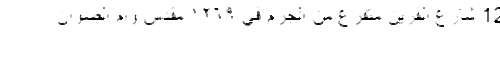

In [ ]:
# Apply median blur
ksize = 3 # Kernel size (should be a positive odd integer)
blurred_image = cv2.medianBlur(adjusted_image, ksize)
cv2_imshow(blurred_image)

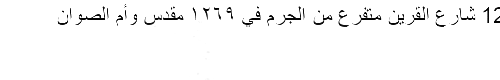

In [ ]:
# Apply non-local means denoising filter
denoised_image = cv2.fastNlMeansDenoising(adjusted_image, None, h=1, templateWindowSize=7, searchWindowSize=1)
cv2_imshow(denoised_image)

Convert the enhanced grayscale image to binary format (black and white) to separate the foreground (text) from the background.

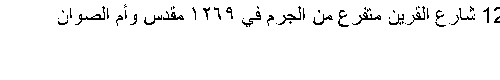

In [ ]:
# Convert the image to binary
_, binary_image = cv2.threshold(denoised_image, 210, 255, cv2.THRESH_BINARY)
cv2_imshow(binary_image)

Image text segmentation:

Contours

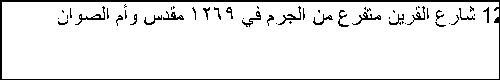

In [ ]:
# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store the bounding boxes
bounding_boxes = []

# Iterate over the contours
for contour in contours:
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Add the bounding box coordinates to the list
    bounding_boxes.append((x, y, x + w, y + h))

# Draw the bounding boxes on the original image
for (x1, y1, x2, y2) in bounding_boxes:
    bounded_image=cv2.rectangle(binary_image, (x1, y1), (x2, y2), (0, 255, 255), 2)

# Display the image with bounding boxes
cv2_imshow(bounded_image)


In [ ]:
bounded_image.shape

(80, 500)

Connected Components:

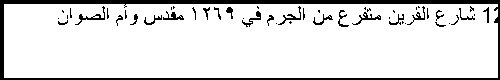

In [ ]:
# Find connected components in the binary image
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Iterate over the connected components
for label in range(1, num_labels):
    # Extract the statistics of the connected component
    left = stats[label, cv2.CC_STAT_LEFT]
    top = stats[label, cv2.CC_STAT_TOP]
    width = stats[label, cv2.CC_STAT_WIDTH]
    height = stats[label, cv2.CC_STAT_HEIGHT]

    # Draw a bounding box around the connected component
    connected_image=cv2.rectangle(binary_image, (left, top), (left + width, top + height), (0, 255, 0), 2)

# Display the text region image with bounding boxes
cv2_imshow( connected_image)

In [ ]:
connected_image.shape

(80, 500)

#### Segmentation with Unet

In [ ]:
'''
def unet(pretrained_weights = None,input_size = (80,50,1)):
    #Creates the UNet model same as the model that was trained to segment page into lines.
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


    if(pretrained_weights):
      model.load_weights(pretrained_weights)

    return model

model=unet()
model.load_weights('./text_seg_model.h5')


line_img_array=[]


def segment_into_lines(filename):
    #Loading the image and performing thresholding on it and then resizing.
    img=cv2.imread(f'{filename}',0)
    ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
    img=cv2.resize(img,(512,512))
    #Expanding the dimension to account for the batch dimension.
    img= np.expand_dims(img,axis=-1)
    #Expanding dimension along channel axis.
    img=np.expand_dims(img,axis=0)
    #Predict the segmentation mask.
    pred=model.predict(img)
    #Remove the batch and channel dimension for performing the binarization.
    pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)


    #Performing the binarization of the predicted mask for contour detection.
    coordinates=[]
    img = cv2.normalize(src=pred, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
    #Opening the original image to get the original dimension information.
    ori_img=cv2.imread(f'{filename}',0)


    (H, W) = ori_img.shape[:2]
    (newW, newH) = (512, 512)
    rW = W / float(newW)
    rH = H / float(newH)

    #Contour detection and bouding box generation.
    contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        #cv2.rectangle(ori_img, (int(x*rW), int(y*rH)), (int((x+w)*rW),int((y+h)*rH)), (255,0,0), 1)
        coordinates.append((int(x*rW),int(y*rH),int((x+w)*rW),int((y+h)*rH)))
    #cv2.imwrite("output.jpg",ori_img)

    #Cropping the lines from the original image using the bouding boxes generated above.
    for i in range(len(coordinates)-1,-1,-1):
        coors=coordinates[i]

        p_img=ori_img[coors[1]:coors[3],coors[0]:coors[2]].copy()

        line_img_array.append(p_img)

    return line_img_array
'''

'\ndef unet(pretrained_weights = None,input_size = (80,50,1)):\n    #Creates the UNet model same as the model that was trained to segment page into lines.\n    inputs = Input(input_size)\n    conv1 = Conv2D(64, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(inputs)\n    conv1 = Conv2D(64, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(conv1)\n    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n    conv2 = Conv2D(128, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(pool1)\n    conv2 = Conv2D(128, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(conv2)\n    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n    conv3 = Conv2D(256, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(pool2)\n    conv3 = Conv2D(256, 3, activation = \'relu\', padding = \'same\', kernel_initializer = \'he_normal\')(conv3)\n    pool3 = MaxPooling2D(po

In [ ]:
'''
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]


    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels
'''

'\ndef get_segmented_img(img,n_classes):\n    """\n    Loads in the segmented image and create suitable segmentation label.\n    """\n    seg_labels=np.zeros((512,512,1))\n    img=cv2.resize(img,(512,512))\n    img=img[:,:,0]\n    cl_list=[0,24]\n\n\n    seg_labels[:,:,0]=(img!=0).astype(int)\n\n\n    return seg_labels\n'

Builing up a preprocessing function


In [ ]:
def imges_preprocessing(img):

    '''
    Input: img read by open cv
    Output: preprocessed img
    '''
    # make sure all images have the same size
    resized_image = cv2.resize(img, (500, 308))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    adjusted_image = cv2.convertScaleAbs(gray_image, alpha=2.2, beta=1)
    denoised_image = cv2.fastNlMeansDenoising(adjusted_image, None, h=1, templateWindowSize=7, searchWindowSize=1)
    _, binary_image = cv2.threshold(denoised_image, 210, 255, cv2.THRESH_BINARY)
    binary_image_dim = np.expand_dims(binary_image, axis=-1)  # Add extra dimension for batch size
    return binary_image_dim


In [ ]:
def images_loader(directory):
    '''
    Input: images path
    Output: a list of preprocessed images, , and a list of image files name
    '''
    images_list=[]
    images_name=[]
    # loop over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            # Read the image using OpenCV
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            binary_img=imges_preprocessing(image)
            images_list.append(binary_img)
            # get rid of extension
            images_name.append(filename.split('.')[0])
    return images_list,images_name



In [ ]:
#images path
directory = 'OCR_Text'
images_list,images_name=images_loader(directory)

In [ ]:

len(images_list)

19992

## Text Preprocessing:


text_normalization

In [ ]:
'''
def text_normalization(text):
    # Removing tashkeel
    diacritics = 'ًٌٍَُِّْ'
    for char in diacritics:
        text = text.replace(char, '')

    # normalizing alef variations
    text = re.sub('[إأآا]', 'ا', text)

    # removing tatweel of alef and lam if they exist
    text = text.replace('لـا', 'لا')

    # convert arabic to english numbers
    arabic_digits = '٠١٢٣٤٥٦٧٨٩'
    english_digits = '0123456789'
    conversion_map = str.maketrans(arabic_digits, english_digits)
    text = text.translate(conversion_map)

    # normalizing hamza
    hamza_variations = 'ئؤآ'
    for char in hamza_variations:
        text = text.replace(char, 'ء')

    # removing tatweel
    text = text.replace('ـ', '')

    # normalizing tashkeel(fatha, kasra,damma)
    kasra_variations = 'ٍِ'
    damma_variations = 'ٌُ'
    fatha_variations = 'ًَ'
    text = text.replace(kasra_variations, 'ِ')
    text = text.replace(damma_variations, 'ُ')
    text = text.replace(fatha_variations, 'َ')

    return text
'''

"\ndef text_normalization(text):\n    # Removing tashkeel\n    diacritics = 'ًٌٍَُِّْ'\n    for char in diacritics:\n        text = text.replace(char, '')\n\n    # normalizing alef variations\n    text = re.sub('[إأآا]', 'ا', text)\n\n    # removing tatweel of alef and lam if they exist\n    text = text.replace('لـا', 'لا')\n\n    # convert arabic to english numbers\n    arabic_digits = '٠١٢٣٤٥٦٧٨٩'\n    english_digits = '0123456789'\n    conversion_map = str.maketrans(arabic_digits, english_digits)\n    text = text.translate(conversion_map)\n\n    # normalizing hamza\n    hamza_variations = 'ئؤآ'\n    for char in hamza_variations:\n        text = text.replace(char, 'ء')\n\n    # removing tatweel\n    text = text.replace('ـ', '')\n\n    # normalizing tashkeel(fatha, kasra,damma)\n    kasra_variations = 'ٍِ'\n    damma_variations = 'ٌُ'\n    fatha_variations = 'ًَ'\n    text = text.replace(kasra_variations, 'ِ')\n    text = text.replace(damma_variations, 'ُ')\n    text = text.replace(fa

In [ ]:
path=directory+'/111.txt'
with open (path,'r') as file:
    file_contents=file.read()
print(file_contents)

911 شارع الرحمانية متفرع من موردين في ١٥٣٥ أبيرلادي


In [ ]:
'''
normalized_text = text_normalization(file_contents)
print(normalized_text)
'''

'\nnormalized_text = text_normalization(file_contents)\nprint(normalized_text)\n'

text feature extraction

In [ ]:
'''
def one_hot_encoding(text):
    # Create a character vocabulary
    characters = sorted(set(text))
    print ("characters",characters)
    char_to_index = {char: i for i, char in enumerate(characters)}
    vocab_size = len(characters)

    # Convert characters to one-hot vectors
    one_hot_vectors = []
    for char in text:
        vector = np.zeros(vocab_size)
        vector[char_to_index[char]] = 1
        one_hot_vectors.append(vector)

    return one_hot_vectors
'''

'\ndef one_hot_encoding(text):\n    # Create a character vocabulary\n    characters = sorted(set(text))\n    print ("characters",characters)\n    char_to_index = {char: i for i, char in enumerate(characters)}\n    vocab_size = len(characters)\n\n    # Convert characters to one-hot vectors\n    one_hot_vectors = []\n    for char in text:\n        vector = np.zeros(vocab_size)\n        vector[char_to_index[char]] = 1\n        one_hot_vectors.append(vector)\n\n    return one_hot_vectors\n'

In [ ]:

'''

# One-Hot Encoding


# Perform one-hot encoding
# Example preprocessed Arabic text
preprocessed_text =  '911 شارع الرحمانية متفرع من موردين في 1535 ابيرلادي'

one_hot_vectors = one_hot_encoding(preprocessed_text)

print("One-Hot Encoding:")
print(one_hot_vectors)
'''

'\n\n# One-Hot Encoding\n\n\n# Perform one-hot encoding\n# Example preprocessed Arabic text\npreprocessed_text =  \'911 شارع الرحمانية متفرع من موردين في 1535 ابيرلادي\'\n\none_hot_vectors = one_hot_encoding(preprocessed_text)\n\nprint("One-Hot Encoding:")\nprint(one_hot_vectors)\n'

In [ ]:
def text_preprocessing(directory):
    '''
    Input: texts path
    Output: a list of preprocessed texts, and a list of text files name
    '''

    texts_list=[]
    texts_name=[]
    # loop over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            # Read the image using OpenCV
            text_path = os.path.join(directory, filename)
            with open (text_path,'r') as file:
                file_contents=file.read()
            texts_list.append(file_contents)
            # get rid of extension
            texts_name.append(filename.split('.')[0])
    return texts_list,texts_name



In [ ]:
texts_list,texts_name=text_preprocessing(directory)


In [ ]:
texts_name[0]

'11779'

In [ ]:
images_name[0]

'19775'

The order of the image files and text files is incompatible, is addition to some files are missing for the text files and vice versa

In [ ]:
# create a dictionary where key is filename and value is the index in images_name list
images_name_index = {name: index for index, name in enumerate(images_name)}

# create a dictionary where key is filename and value is the index in texts_name list
texts_name_index = {name: index for index, name in enumerate(texts_name)}

# find the common filenames
common_filenames = set(images_name_index.keys()) & set(texts_name_index.keys())

# for each common filename, get the corresponding image and text using their indices
filtered_image_indices = [images_name_index[name] for name in common_filenames]
filtered_image_list = [images_list[i] for i in filtered_image_indices]
filtered_text_list = [texts_list[texts_name_index[name]] for name in common_filenames]

# we'll sort both lists based on the image indices to ensure they're in the same order
# get a list of tuples where each tuple is (image_index, image, text)
paired_list = list(zip(filtered_image_indices, filtered_image_list, filtered_text_list))

# sort the list of tuples based on the image indices
paired_list.sort(key=lambda x: x[0])

# unzip the list of tuples back into two separate lists, discarding the indices
_, filtered_image_list, filtered_text_list = zip(*paired_list)

In [ ]:
print(len(filtered_image_list))
print(len(filtered_text_list))


19975
19975


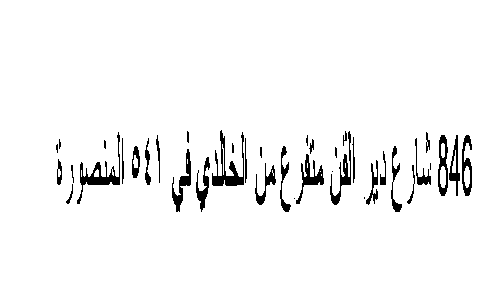

In [ ]:
cv2_imshow(filtered_image_list[222])

In [ ]:
print( filtered_text_list[222])


846 شارع دير القن متفرع من الخالدي في ٥٤١ المنصورة


In [100]:
def text_loader(texts):
    '''
    Input: texts list
    Output: a list of encoded padded text in the char level
    '''
    # create a character set
    charset = set(''.join(texts))  # Replace 'texts' with your list of texts
    charset.add('<PAD>')  # Add a special padding character

    # create a tokenizer
    tokenizer = Tokenizer(char_level=True)  # Set char_level=True to encode at the character level
    tokenizer.fit_on_texts(list(charset))

    # encode text
    sequences = tokenizer.texts_to_sequences(texts)

    # pad sequences
    sequences = pad_sequences(sequences)
    return sequences, tokenizer




In [ ]:
sequences,_= text_loader(filtered_text_list)

In [ ]:
sequences.shape

(19975, 77)

#### Embedding

In [ ]:
'''

# Example preprocessed Arabic text
preprocessed_text = '911 شارع الرحمانية متفرع من موردين في 1535 ابيرلادي'

# Tokenize the text into characters
tokenized_text = list(preprocessed_text)

# Train character embeddings using Word2Vec
embedding_size = 100  # Specify the desired embedding size
window_size = 5  # The maximum distance between the current and predicted character within a sentence
min_count = 1  # Minimum frequency count of characters to consider for training

model = Word2Vec(sentences=[tokenized_text], vector_size=embedding_size, window=window_size, min_count=min_count)

# Get the vocabulary of characters and their corresponding embeddings
vocab = model.wv.index_to_key
character_embeddings = {character: model.wv[character] for character in vocab}

# Example usage: Get the embedding for a specific character
character = 'ش'
embedding = character_embeddings[character]
print("Character Embedding for", character)
print(embedding)
'''

'\n\n# Example preprocessed Arabic text\npreprocessed_text = \'911 شارع الرحمانية متفرع من موردين في 1535 ابيرلادي\'\n\n# Tokenize the text into characters\ntokenized_text = list(preprocessed_text)\n\n# Train character embeddings using Word2Vec\nembedding_size = 100  # Specify the desired embedding size\nwindow_size = 5  # The maximum distance between the current and predicted character within a sentence\nmin_count = 1  # Minimum frequency count of characters to consider for training\n\nmodel = Word2Vec(sentences=[tokenized_text], vector_size=embedding_size, window=window_size, min_count=min_count)\n\n# Get the vocabulary of characters and their corresponding embeddings\nvocab = model.wv.index_to_key\ncharacter_embeddings = {character: model.wv[character] for character in vocab}\n\n# Example usage: Get the embedding for a specific character\ncharacter = \'ش\'\nembedding = character_embeddings[character]\nprint("Character Embedding for", character)\nprint(embedding)\n'

In [ ]:
'''
def char_features(address):
    # Character-level features
    char_tokenizer = Tokenizer(char_level=True)
    char_tokenizer.fit_on_texts(address)
    char_sequences = char_tokenizer.texts_to_sequences(address)
    max_char_length = max(len(seq) for seq in char_sequences)
    padded_char_sequences = pad_sequences(char_sequences, maxlen=max_char_length)
    char_vocab_size = len(char_tokenizer.word_index) + 1

    char_input = Input(shape=(max_char_length,))
    char_embedding_dim = 50
    char_embedding_layer = Embedding(char_vocab_size, char_embedding_dim)(char_input)
    char_cnn_filters = 100
    char_cnn_kernel_size = 3
    char_cnn = Conv1D(filters=char_cnn_filters, kernel_size=char_cnn_kernel_size, activation='relu')(char_embedding_layer)
    char_pooling = GlobalMaxPooling1D()(char_cnn)
    return char_pooling

'''

"\ndef char_features(address):\n    # Character-level features\n    char_tokenizer = Tokenizer(char_level=True)\n    char_tokenizer.fit_on_texts(address)\n    char_sequences = char_tokenizer.texts_to_sequences(address)\n    max_char_length = max(len(seq) for seq in char_sequences)\n    padded_char_sequences = pad_sequences(char_sequences, maxlen=max_char_length)\n    char_vocab_size = len(char_tokenizer.word_index) + 1\n\n    char_input = Input(shape=(max_char_length,))\n    char_embedding_dim = 50\n    char_embedding_layer = Embedding(char_vocab_size, char_embedding_dim)(char_input)\n    char_cnn_filters = 100\n    char_cnn_kernel_size = 3\n    char_cnn = Conv1D(filters=char_cnn_filters, kernel_size=char_cnn_kernel_size, activation='relu')(char_embedding_layer)\n    char_pooling = GlobalMaxPooling1D()(char_cnn)\n    return char_pooling\n\n"

In [ ]:
'''
def word_feature(address):
    word_tokenizer = Tokenizer()
    word_tokenizer.fit_on_texts(address)
    word_sequences = word_tokenizer.texts_to_sequences(address)
    max_word_length = max(len(seq) for seq in word_sequences)
    padded_word_sequences = pad_sequences(word_sequences, maxlen=max_word_length)
    word_vocab_size = len(word_tokenizer.word_index) + 1

    word_input = Input(shape=(max_word_length,))
    word_embedding_dim = 100
    word_embedding_layer = Embedding(word_vocab_size, word_embedding_dim)(word_input)
    word_pooling = GlobalMaxPooling1D()(word_embedding_layer)
    return word_pooling
'''

'\ndef word_feature(address):\n    word_tokenizer = Tokenizer()\n    word_tokenizer.fit_on_texts(address)\n    word_sequences = word_tokenizer.texts_to_sequences(address)\n    max_word_length = max(len(seq) for seq in word_sequences)\n    padded_word_sequences = pad_sequences(word_sequences, maxlen=max_word_length)\n    word_vocab_size = len(word_tokenizer.word_index) + 1\n\n    word_input = Input(shape=(max_word_length,))\n    word_embedding_dim = 100\n    word_embedding_layer = Embedding(word_vocab_size, word_embedding_dim)(word_input)\n    word_pooling = GlobalMaxPooling1D()(word_embedding_layer)\n    return word_pooling\n'

In [ ]:
'''
# Hybrid features
hybrid_input = Concatenate()([word_pooling, char_pooling])
hybrid_input
'''

'\n# Hybrid features\nhybrid_input = Concatenate()([word_pooling, char_pooling])\nhybrid_input\n'

In [ ]:
'''
# Handcrafted features
handcrafted_features = []
for address in addresses:
    has_numbers = float(any(char.isdigit() for char in address))
    has_special_characters = float(any(not char.isalnum() for char in address))
    handcrafted_features.append([has_numbers, has_special_characters])
handcrafted_features = np.array(handcrafted_features)
handcrafted_features
'''

'\n# Handcrafted features\nhandcrafted_features = []\nfor address in addresses:\n    has_numbers = float(any(char.isdigit() for char in address))\n    has_special_characters = float(any(not char.isalnum() for char in address))\n    handcrafted_features.append([has_numbers, has_special_characters])\nhandcrafted_features = np.array(handcrafted_features)\nhandcrafted_features\n'

In [ ]:
'''
# Combine all features
combined_features = Concatenate()([word_pooling, char_pooling, hybrid_input, handcrafted_features])
combined_features
'''

'\n# Combine all features\ncombined_features = Concatenate()([word_pooling, char_pooling, hybrid_input, handcrafted_features])\ncombined_features\n'

In [ ]:
'''
# Pass the combined features through a dense layer for classification
output_units = 1
dense_units = 64
dense_layer = Dense(units=dense_units, activation='relu')(combined_features)
output_layer = Dense(units=output_units, activation='sigmoid')(dense_layer)

# Define the model
model = Model(inputs=[word_input, char_input], outputs=output_layer)

# Print the model summary
model.summary()
'''

"\n# Pass the combined features through a dense layer for classification\noutput_units = 1\ndense_units = 64\ndense_layer = Dense(units=dense_units, activation='relu')(combined_features)\noutput_layer = Dense(units=output_units, activation='sigmoid')(dense_layer)\n\n# Define the model\nmodel = Model(inputs=[word_input, char_input], outputs=output_layer)\n\n# Print the model summary\nmodel.summary()\n"

## Modeling:

In [ ]:

size=len(filtered_image_list)
training_images = filtered_image_list[:int(0.7 * size)]
training_texts = sequences[:int(0.7 * size)]

testing_images = filtered_image_list[int(0.7 * size)+1:size+1]
testing_texts = sequences[int(0.7 * size)+1:size+1]
# Convert your data to numpy arrays
training_images = np.array(training_images)
training_texts = np.array(training_texts)
testing_images = np.array(testing_images)
testing_texts = np.array(testing_texts)
print(len(training_images))
print(len(training_texts))
print(len(testing_images))
print(len(testing_texts))

13982
13982
5992
5992


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU is available.")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU is not available.")

GPU is available.


In [ ]:
# Define your model architecture
input_shape = (308, 500, 1)  # Adjusted for new image size, 308 / 2 / 2 = 77
inputs = Input(name='the_input', shape=input_shape, dtype='float32')

# CNN part
inner = Conv2D(32, (3, 3), padding='same', name='conv1', activation='relu')(inputs)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', activation='relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

# Reshape tensor before feeding to RNN part
conv_to_rnn_dims = (77, (500 // (2 ** 2)) * 64)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# RNN part
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

# Output layer
# The number of unique characters is the dimensionality of the output
num_unique_chars = sequences.max() + 1  # The highest integer in your encoded sequences is the total number of unique characters
# One-hot encoding
sequences_onehot_train = to_categorical(training_texts, num_classes=num_unique_chars)
sequences_onehot_test= to_categorical(testing_texts, num_classes=num_unique_chars)

inner = TimeDistributed(Dense(num_unique_chars, activation='softmax'), name='dense')(inner)



In [ ]:
# Compile model
model = Model(inputs=inputs, outputs=inner)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train your model
history=model.fit(training_images, sequences_onehot_train, validation_data=(testing_images, sequences_onehot_test), epochs=10, batch_size=12)

Epoch 1/10
1166/1166 [==============================] - 120s 88ms/step - loss: 2.0427 - accuracy: 0.4447 - val_loss: 1.9765 - val_accuracy: 0.4522
Epoch 2/10
1166/1166 [==============================] - 100s 86ms/step - loss: 1.9869 - accuracy: 0.4494 - val_loss: 1.9733 - val_accuracy: 0.4500
Epoch 3/10
1166/1166 [==============================] - 99s 85ms/step - loss: 1.9818 - accuracy: 0.4498 - val_loss: 1.9735 - val_accuracy: 0.4517
Epoch 4/10
1166/1166 [==============================] - 99s 85ms/step - loss: 1.9794 - accuracy: 0.4498 - val_loss: 1.9641 - val_accuracy: 0.4514
Epoch 5/10
1166/1166 [==============================] - 99s 85ms/step - loss: 1.9763 - accuracy: 0.4502 - val_loss: 1.9786 - val_accuracy: 0.4492
Epoch 6/10
1166/1166 [==============================] - 100s 85ms/step - loss: 1.9749 - accuracy: 0.4503 - val_loss: 1.9661 - val_accuracy: 0.4509
Epoch 7/10
1166/1166 [==============================] - 99s 85ms/step - loss: 1.9741 - accuracy: 0.4505 - val_loss: 1.963

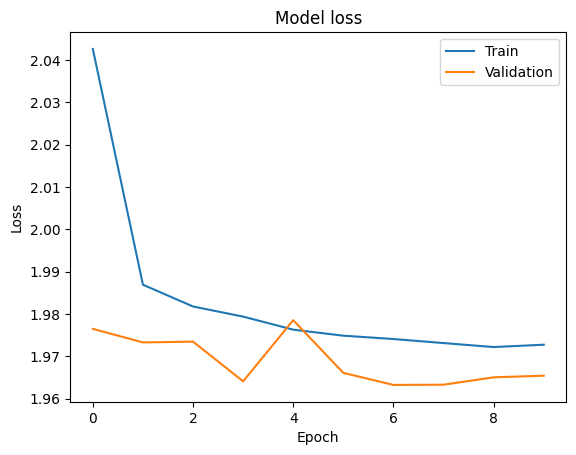

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# save the model:
model.save('/content/drive/MyDrive/OCR/ocr.h5')

In [182]:


onnx_model,_ = tf2onnx.convert.from_keras(model)

# Save the ONNX model to a file
onnx.save_model(onnx_model,'/content/drive/MyDrive/OCR/ocr.onnx')


## Model Inference:

In [ ]:

# Load the trained OCR model
model = keras.models.load_model('/content/drive/MyDrive/OCR/ocr.h5')

In [111]:
#  image preprocessing function
def preprocess_image_predict(image_path):

    '''
    Input: image path
    Output: preprocessed img
    '''
    # make sure all images have the same size
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (500, 308))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    adjusted_image = cv2.convertScaleAbs(gray_image, alpha=2.2, beta=1)
    denoised_image = cv2.fastNlMeansDenoising(adjusted_image, None, h=1, templateWindowSize=7, searchWindowSize=1)
    _, binary_image = cv2.threshold(denoised_image, 210, 255, cv2.THRESH_BINARY)
    binary_image_dim = np.expand_dims(binary_image, axis=-1)  # Add extra dimension for batch size
    return binary_image_dim


sequences, tokenizer = text_loader(filtered_text_list)


def decode_predictions(predictions, tokenizer):
    # Reverse the tokenizer's word index
    reverse_word_index = dict((i, char) for char, i in tokenizer.word_index.items())

    # Convert the predictions from one-hot encoding to integers
    prediction_integers = np.argmax(predictions, axis=-1)

    # Initialize an empty list to hold the decoded predictions
    decoded_predictions = []

    # Iterate over the sequences in the prediction
    for sequence in prediction_integers:
        # Convert each integer in the sequence to its corresponding character
        # and join them together to form a string
        decoded_sequence = []
        for i in sequence:
            char = reverse_word_index.get(i)
            if char is None:
                continue
            else:
                decoded_sequence.append(char)
        decoded_predictions.append(''.join(decoded_sequence))

    return decoded_predictions
# Inference function
def predict(model, image, tokenizer):
    # Preprocess the image
    preprocessed_image = preprocess_image_predict(image)

    # Make a prediction
    predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Decode the predictions
    decoded_predictions = decode_predictions(predictions, tokenizer)

    return decoded_predictions



1/1 [==============================] - 0s 23ms/step
['                                        لريية']


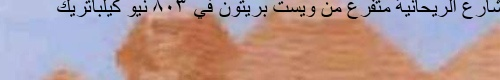

In [116]:
# Usage
image = 'OCR_Text/100.jpg' # This should be one of your test images
print(predict(model, image, tokenizer))
image = cv2.imread(image)
cv2_imshow(image)

## Deployment:


Model Conversion:


In [129]:

import tensorrt as trt

print("TensorRT version: ")
print(trt.__version__)

TensorRT version: 
8.6.1


In [ ]:
#!docker pull nvcr.io/nvidia/tensorrt:21.02-py3

In [ ]:
#!docker run --gpus all -it --rm -v local_dir:container_dir nvcr.io/nvidia/tensorrt:21.02-py3

In [141]:
# Save the Keras model to SavedModel format
model.save('/content/drive/MyDrive/OCR/ocr_saved_model')

# Load a SavedModel in TensorFlow
saved_model_loaded = tf.saved_model.load('/content/drive/MyDrive/OCR/ocr_saved_model', tags=[tag_constants.SERVING])

# Convert the SavedModel using tf-trt
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='/content/drive/MyDrive/OCR/ocr_saved_model',
    conversion_params=conversion_params
)

# Convert the model
converter.convert()

# Optimize the model
def input_fn():
    input_shapes = [1, 308, 500, 1]  # Change this as per the input shape your model expects
    yield [np.zeros(input_shapes).astype(np.float32)]
converter.build(input_fn)

# Save the optimized TensorRT model for inference
converter.save('/content/drive/MyDrive/OCR/optimized_model')

End Point using Django

In [173]:
%cd ..

/content


In [174]:
!django-admin startproject endpoint

In [176]:
%cd endpoint
!python manage.py startapp endpointapp

/content/endpoint


In [186]:
!python manage.py runserver

Watching for file changes with StatReloader
Performing system checks...

2023-09-06 20:31:17.548944: F tensorflow/compiler/tf2tensorrt/stub/nvinfer_stub.cc:49] createInferRuntime_INTERNAL symbol not found.


In [188]:
!zip -r /content/endpoint.zip /content/endpoint

  adding: content/endpoint/ (stored 0%)
  adding: content/endpoint/endpointapp/ (stored 0%)
  adding: content/endpoint/endpointapp/__pycache__/ (stored 0%)
  adding: content/endpoint/endpointapp/__pycache__/urls.cpython-310.pyc (deflated 23%)
  adding: content/endpoint/endpointapp/__pycache__/__init__.cpython-310.pyc (deflated 31%)
  adding: content/endpoint/endpointapp/__pycache__/views.cpython-310.pyc (deflated 31%)
  adding: content/endpoint/endpointapp/views.py (deflated 60%)
  adding: content/endpoint/endpointapp/.ipynb_checkpoints/ (stored 0%)
  adding: content/endpoint/endpointapp/tests.py (deflated 3%)
  adding: content/endpoint/endpointapp/urls.py (deflated 25%)
  adding: content/endpoint/endpointapp/models.py (deflated 5%)
  adding: content/endpoint/endpointapp/admin.py (deflated 2%)
  adding: content/endpoint/endpointapp/apps.py (deflated 26%)
  adding: content/endpoint/endpointapp/__init__.py (stored 0%)
  adding: content/endpoint/endpointapp/migrations/ (stored 0%)
  addin